#Brain Tumor Classification using ResNet-50


This notebook presents a deep learning pipeline for classifying brain tumors from MRI images using transfer learning with the ResNet-50 model.

###  Project Goals:
- Classify brain MRI scans into 4 categories: Glioma, Meningioma, Pituitary Tumor, or No Tumor.
- Achieve high accuracy using a pretrained model (ResNet-50).
- Support early diagnosis and reduce the burden on radiologists.

### Results:
- Final model achieved **98% test accuracy** after fine-tuning.

### Dataset:
- Source: [Kaggle – Brain Tumor MRI Dataset](https://www.kaggle.com/datasets/masoudnickparvar/brain-tumor-mri-dataset/data)
- Total images: 7,023
- Train/test split: 78% / 22%

---
This notebook was developed as a final project for an Introduction to Artificial Intelligence course by Maya Kimhi.

---



# Table of contents:
1. Introduction
2. Data Loading & Preprocessing
3. Data Augmentation
4. Transfer Learning
5. Model Compilation
6. Training the model
7. Results & Evaluation of the model
8. Fine Tuning
9. Results & Evaluation of the model after Fine Tuning
10. Conclusion & Further suggestions
12. Difficulties along the way

#1.Introduction
Brain tumor is an abnormal growth of cells in the brain or spine that can disrupt proper brain function. brain tumors pose a diagnostic challenge due to the blood-brain barrier.  
If left untreated or misdiagnosed, leading to inappropriate treatment, brain tumors may proliferate and cause cerebral damage, potentially resulting in life-threatening consequences.
Early detection and classification of brain tumors are an important research domain in the field of medical imaging and accordingly helps in selecting the most appropriate treatment method to save patients life therefore

Currently, MRI or CT scans are the primary diagnostic tools for detecting brain tumors. Decoding MRI results requires specialized skills that radiologists acquire through extensive specialization.
in Israel, there is a shortage of radiologists, which leads to errors in interpretation and longer waiting times for test results.

Several AI models have been developed to address these issues. Certain models improve the resolution of CT and MRI images, facilitating the interpretation process. Others analyze imaging results, alerting radiologists when anomalies are detected and prioritizing these cases for earlier interpretation by a radiologist. However, these models do not yet independently classify specific health conditions; radiologists interpret the results completely on their own.

##Purpose of the project
This project aims to achieve high classification accuracy in classifying brain tumors from MRI imaging, in order to achieve the following goals:
1. Reduce the percentage of incorrect diagnoses, which currently stands at 10 to 20 percent.
2. Shorten the waiting time for results, which currently ranges from 7 business days to up to three weeks.

###The data for this project:
I will use a publicly available Brain Tumor MRI Dataset for classify brain tumors.         
The dataset contains 7,023 images of human brain MRI images which are classified into 4 classes: Glioma Tumor, Meningioma Tumor, Pituitary Tumor, No Tumor
[Dataset link](https://www.kaggle.com/datasets/masoudnickparvar/brain-tumor-mri-dataset/data)      

The dataset provides the data when it labled and already divided into test and train.        
About 22% of the images are assigned for model testing and the remaining 78% for model training.

The size of MRI images in this dataset s not unified.
I will resize images to the 224*224 size(fits for ResNet50)  after pre-processing and removing the extra margins.


In [ ]:
import numpy as np
import os
import matplotlib.pyplot as plt
import tensorflow as tf
import pandas as pd
import seaborn as sns
from tensorflow.keras.preprocessing.image import load_img, img_to_array
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.applications.resnet50 import preprocess_input
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.losses import CategoricalCrossentropy
from tensorflow.keras.layers import Input
from tensorflow.keras.callbacks import EarlyStopping
from sklearn.metrics import classification_report, confusion_matrix

#2. Data Loading & Preprocesessing
###Setting definitions:
First thing I will define the path of train and test.  

In [ ]:
train_dir = '/content/drive/MyDrive/BT/BrainTumorMRI_dataset/Training'
test_dir = '/content/drive/MyDrive/BT/BrainTumorMRI_dataset/Testing'

Next I define the optional lables for the images in a list, and create an empty lists for train images, train correct labels, test images, test correct labels. Then I define the image size that I will convert all images to.

In [ ]:
labels = ['glioma', 'meningioma', 'pituitary', 'notumor']

In [ ]:
x_train = []  # A list that will contain the images for training the model.
y_train = []  # # A list that will contain the labels of images that are for trainin the model
x_test = []   # # A list that will contain the images for testing the model.
y_test = []   #  A list that will contain the labels of images for testing the model.

In [ ]:
image_size = 224

### Loading, Resizing and Normalizing data:
Data are divided for testing and training according to the distribution of data in the dataset.  **X - images, Y - labels**.      
For each label:       
**os.path.join()**:a function that combines between two given aguments in order to create a specific path. I used it in the first time for creating a path for the different categories, and after that, for creating a path to images in spesific category.       
**listdir()**: A function that lists files and directiories  in a specified directory.          
returns a list containing the names of the files and subdirectories in the given directory (takes a path to a directory).       
**load_img()**: a function that load image from path and resizing it to target size.       
**img_to_array()**: a function that converting the loaded image into a numpy array as image size and number of color channels.         
**preprocess_input()**: this function normalizing the image so it will match especially to ResNet-50 model's .


In [ ]:
# Loading training data
for label in labels: #for each category
    folder_path = os.path.join(train_dir, label) #creating the specific path to the category
    for img_name in os.listdir(folder_path): #for each image in specific category
        img_path = os.path.join(folder_path, img_name) #creating the specific path for specific image in specific category
        img = load_img(img_path, target_size=(image_size, image_size)) #Loading image from the specific path and resizing it to the target size.
        img_array = img_to_array(img) #converting the image into a array.
        img_array = preprocess_input(img_array) #normalizing the image so that it matches the input for ResNet-50 model.
        x_train.append(img_array) #adding the preprocessed image as array to the x_train list that stores all training images.
        y_train.append(labels.index(label)) # adding the label's index to the y_train list that stores the matching labels (as numbers:0/1/2/3) to the training images.

# Loading testing data - the same as the loop above
for label in labels:
    folder_path = os.path.join(test_dir, label)
    for img_name in os.listdir(folder_path):
        img_path = os.path.join(folder_path, img_name)
        img = load_img(img_path, target_size=(image_size, image_size))
        img_array = img_to_array(img)
        img_array = preprocess_input(img_array)
        x_test.append(img_array)
        y_test.append(labels.index(label))

In [ ]:
print(f"Number of training images: {len(x_train)}")
print(f"Number of labels of training images: {len(y_train)}")
print(f"Number of testing images: {len(x_test)}")
print(f"Number of labels of testing images: {len(y_test)}")

Number of training images: 5781
Number of labels of training images: 5781
Number of testing images: 1311
Number of labels of testing images: 1311


In [ ]:
x_train = np.array(x_train) #converting all lists into a numpy arrays
y_train = np.array(y_train)
x_test = np.array(x_test)
y_test = np.array(y_test)

####chacking the data shape:

In [ ]:
print("Training data shape:", x_train.shape)
print("Training labels shape:", y_train.shape)
print("Test data shape:", x_test.shape)
print("Test labels shape:", y_test.shape)

Training data shape: (5781, 224, 224, 3)
Training labels shape: (5781,)
Test data shape: (1311, 224, 224, 3)
Test labels shape: (1311,)


In [ ]:
print("Numeric labels Before One Hot Encoding:\n", y_train[0])

Numeric labels Before One Hot Encoding:
 0


## One Hot Encoding
one hot encoding for labels.       
converting the categorical labels into a binary matrix for multi-class classification. working on y (y_train and y_test).

**to_categorical()**: converts list of categorial labels into a binary matrix representation.

In [ ]:
y_train = to_categorical(y_train, num_classes=len(labels))
y_test = to_categorical(y_test, num_classes=len(labels))

####chacking the data shape after one hot encoding:

In [ ]:
print("Training data shape:", x_train.shape)
print("Training labels shape:", y_train.shape)
print("Test data shape:", x_test.shape)
print("Test labels shape:", y_test.shape)

Training data shape: (5781, 224, 224, 3)
Training labels shape: (5781, 4)
Test data shape: (1311, 224, 224, 3)
Test labels shape: (1311, 4)


In [ ]:
print("One-hot encoded label:\n", y_train[0])

One-hot encoded label:
 [1. 0. 0. 0.]


####Visualizing a few sample images before data augmentation.    
Using Matplotlib and NumPy libraries to visualize.              
**plt.subplots()**: defining how many rows and coulums of subplots in the figure.       
**figsize=()**:defining the size of the entire figure in inches.       
**np.argmax()**:converting the one-hot encoded y_train into class indices.      
**np.where(... == i)**:finding indices where the class label matches the current index i.
**axes[i].imshow()**:Displaying the image in the i subplot.      
**axes[i].set_title(label)**:sets the title of the subplot according to the images' class label.       
**plt.show()**: displaying the figure with all subplots.

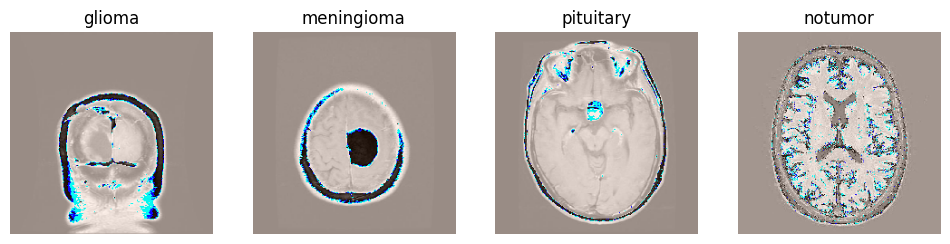

In [ ]:
fig, axes = plt.subplots(1, 4, figsize=(12, 5)) #definding the size and look of figure

for i, label in enumerate(labels): #for each label and its index - displaying images corresponding to each class.
    img_idx = np.where(np.argmax(y_train, axis=1) == i)[0][0]  #finding the index of an image that belongs to the class label.
    axes[i].imshow(x_train[img_idx].astype('uint8')) #display the image in the i subplot in the standard format for image display.
    axes[i].set_title(label) #sets the title of the subplot
    axes[i].axis('off') #hides the axis lines and labels.

plt.show()

####Visualizing the distribution of training images in each class.

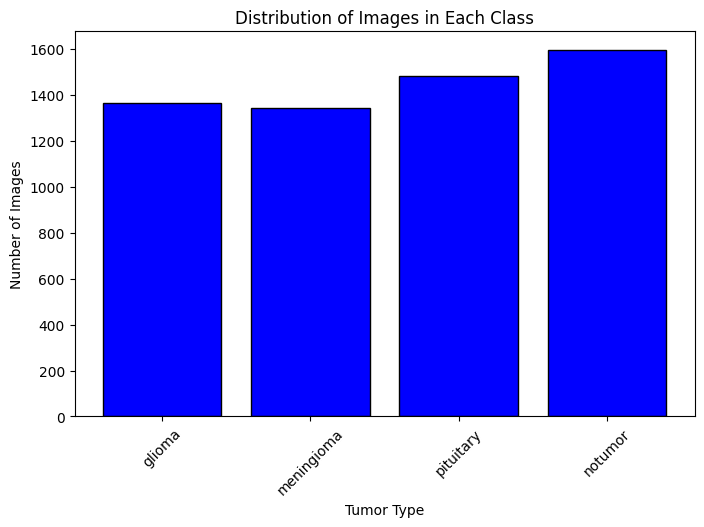

In [ ]:
class_counts = [np.sum(np.argmax(y_train, axis=1) == i) for i in range(len(labels))] #counting the number of images for each category

plt.figure(figsize=(8, 5)) #defining the figure size.
plt.bar(labels, class_counts, color='blue', edgecolor='black') #defining the grid type, date and colors.
plt.title('Distribution of Images in Each Class') #giving the figure a title
plt.xlabel('Tumor Type') #X axis title
plt.ylabel('Number of Images') #y axis title
plt.xticks(rotation=45) #edditing the presentation of labels acorrding to thier length and number.
plt.show() #displaying the figure with all subplots.

#3.Data Augmentation
I will preform data augmentation in ordder to reduces the chance for overfitting,  to maximizing Transfer Learning efficiency, to ensures that my model will classify between multiple classes properlly - even with not big data set.         
data augmentation is preformed on train images only!!!

**rotation_range**: Defines the range in which images will be randomly rotated            
**width_shift_range**: The image can be shifted left or right by up to 100xgiven number of its width(for 0.2, up to 20%).          
**height_shift_range**: The image can be shifted up or down by up to 100xgiven number of its height (for 0.2, up to 20%).   
**shear_range**:The tilting of an image along the axes.        
**zoom_range**: The image will be zoomed in or out randomly within the given range.                
**horizontal_flip=True**:randomly flips half of the images horizontally.      
**fill_mode='nearest'**:When the image is transformed, some pixels might go out of the bounds of the image. This parameter defines how to fill in those missing pixels. 'nearest' means the empty space will be filled with the nearest pixel values from the image (As I learned in an introductory data science course, about imputation).

In [ ]:
datagen_train = ImageDataGenerator(
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest'
)

In [ ]:
datagen_train.fit(x_train) # Fitting generator to my training data
datagen_test = ImageDataGenerator() # Data generator for testing (no augmentation)

**np.expand_dims(img, axis=0)**: Adding an extra dimension at the start of the array, so the image will fit to 'ImageDataGenerator.flow()' as input.     
**next(...)**:pull off the first batch from the generator.       
**datagen.flow()**:Generates batches of augmented images

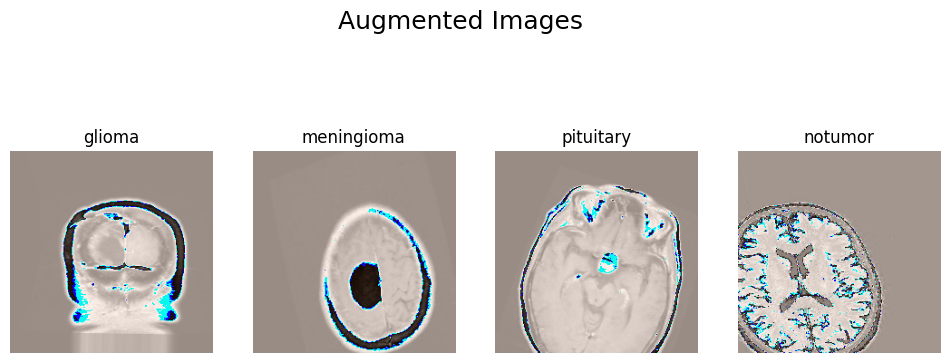

In [ ]:
fig, axes = plt.subplots(1, 4, figsize=(12, 5)) #defining how many rows and coulums of subplots in the figure.
fig.suptitle('Augmented Images', fontsize=18) #Setting the title for the figure.

for i in range(4): #there are 4 labels, so for each label
    img = x_train[np.where(np.argmax(y_train, axis=1) == i)[0][0]] #taking the first image
    img = np.expand_dims(img, axis=0) #Reshaping images so they will fit to data generator (adding an extra dimension)
    augmented_img = next(datagen_train.flow(img, batch_size=1)) #gives back the first batch of agumented image.
    axes[i].imshow(augmented_img[0].astype('uint8')) #display the agumented image in the i subplot in the standard format for image display.
    axes[i].set_title(labels[i]) #give a title to the subplot according to the image label
    axes[i].axis('off') #hide the subplot axis lines and labels.

plt.show() #display the full figure

# 4. Transfer Learning
### Load the Pre-trained Model - ResNet50
Importing the pre-trained model "ResNet50" from tensorflow and afterwards Loading ResNet50 without the top layer.

The last layer of ResNet50 model on ImageNet is a dense layer of 1000 units, representing the 1000 possible classes in the dataset.       
In this project, I want the model to make classification for 4 possible classes, that is why I import ResNet50 without its top layer.               
By setting the flag **include_top=False** I imported the model without its top layer.

In order to use ResNet50 for classification in a way that will provide a better results, I use the knowledge that its acquired when it learned to classify various different types of images (when it pre-trained with a big dataset - ImageNet dataset) .         
This "knowledge" that I am reffering to is detecting many different types of features that could be valuable in image recognition.         
By setting **weights='imagenet'**, I Load the weights thet were pre-trained on ImageNet dataset.

Defining the shape of the images that the model workes on By **input_shape=(224, 224, 3)**

In [ ]:
base_model = ResNet50(weights='imagenet', include_top=False, input_shape=(224, 224, 3))

checking the summary of the model after my definition in importing it.

In [ ]:
base_model.summary()

Model: "resnet50"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)  │ (None, 224, 224, 3)    │              0 │ -                      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv1_pad (ZeroPadding2D) │ (None, 230, 230, 3)    │              0 │ input_layer[0][0]      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv1_conv (Conv2D)       │ (None, 112, 112, 64)   │          9,472 │ conv1_pad[0][0]        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv1_bn                  │ (None, 112, 112, 64)   │            256 │ conv1_conv[0][0]       │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv1_relu (Activation)   │ (None, 112, 112, 64)   │              0 │ conv1_bn[0][0]         │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ pool1_pad (ZeroPadding2D) │ (None, 114, 114, 64)   │              0 │ conv1_relu[0][0]       │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ pool1_pool (MaxPooling2D) │ (None, 56, 56, 64)     │              0 │ pool1_pad[0][0]        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_1_conv       │ (None, 56, 56, 64)     │          4,160 │ pool1_pool[0][0]       │
│ (Conv2D)                  │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_1_bn         │ (None, 56, 56, 64)     │            256 │ conv2_block1_1_conv[0… │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_1_relu       │ (None, 56, 56, 64)     │              0 │ conv2_block1_1_bn[0][… │
│ (Activation)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_2_conv       │ (None, 56, 56, 64)     │         36,928 │ conv2_block1_1_relu[0… │
│ (Conv2D)                  │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_2_bn         │ (None, 56, 56, 64)     │            256 │ conv2_block1_2_conv[0… │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_2_relu       │ (None, 56, 56, 64)     │              0 │ conv2_block1_2_bn[0][… │
│ (Activation)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_0_conv       │ (None, 56, 56, 256)    │         16,640 │ pool1_pool[0][0]       │
│ (Conv2D)                  │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_3_conv       │ (None, 56, 56, 256)    │         16,640 │ conv2_block1_2_relu[0… │
│ (Conv2D)                  │                        │                │                        │
├──────────────────────

 Total params: 23,587,712 (89.98 MB)

 Trainable params: 23,534,592 (89.78 MB)

 Non-trainable params: 53,120 (207.50 KB)

###Freezing the Base Model
I freeze the ResNet50 layers that I import while training new layers, in order to save the learning achieved of the model from training on the ImageNet dataset. If these layers will be unfrozen at the stage of training the new layer that I will add, I will likely destroy this valuable information, what makes the transfer learining useless.          
I will freeze the ResNet50 layers by **model.trainable = False**

In [ ]:
base_model.trainable = False

###Adding New Layers
I will begein with one fully connected layer (Danse layer) and if needed I will add more layers. I will begien from only one layer becuase that as models become more complex the risk of overfitting rises

**GlobalAveragePooling2D()**: acts similar to the Max Pooling layer in CNNs, the difference is that it uses the Average values instead of the Max value while pooling. It helps decreasing the number of parameters and helps avoid overfitting.     
**Dense()**: adding Fully Connected Layer.This is the output layer which classifies the image into 1 of the 4 possible classes. It uses the softmax function which is a generalization of the sigmoid function.       
softmax activation function-  uses in output layer of classification model, especially for multi-class classification. Its role is to convert the raw output scores from the final dense layer into probabilities for each class.      
**training=False**:preventing from the weights of the ResNet-50 layers from being updated during training.

In [ ]:
inputs = Input(shape=(224, 224, 3)) #As I changed the MRI images to be
x = base_model(inputs, training=False) # Separately from setting trainable on the model, we set training to False
x = GlobalAveragePooling2D()(x)  # Global average pooling layer
outputs = Dense(4, activation='softmax')(x)  # Output layer with 4 ptational units (for 4 classes) and softmax activation

In [ ]:
model = Model(inputs, outputs) # Creating the full model

#5. Model Compilation     
**model.compile()**:configuring the model's training process - what type will be the optimizer, the loss function and the metrics that valuate the model during training.       
**adam**:using adam optimizer for gradient descent, usually requires less tuning of the learning rate and works well in many situations.       
**categorical_crossentropy**: used for classification tasks where the labels are one-hot encoded, appropriate for multi-class classification problems.       
**[tf.keras.metrics.CategoricalAccuracy()]**:calculates the percentage of correctly predicted labels out of the total predictions. For classification tasks, accuracy is a commonly used metric to gauge model performance.

In [ ]:
model.compile(optimizer='adam', loss=CategoricalCrossentropy(), metrics=['accuracy'])

In [ ]:
model.summary()

Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_4 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 resnet50 (Functional)       (None, 7, 7, 2048)        23587712  
                                                                 
 global_average_pooling2d_1  (None, 2048)              0         
  (GlobalAveragePooling2D)                                       
                                                                 
 dense_1 (Dense)             (None, 4)                 8196      
                                                                 
Total params: 23595908 (90.01 MB)
Trainable params: 8196 (32.02 KB)
Non-trainable params: 23587712 (89.98 MB)
_________________________________________________________________


Plot of Model Archtecture:

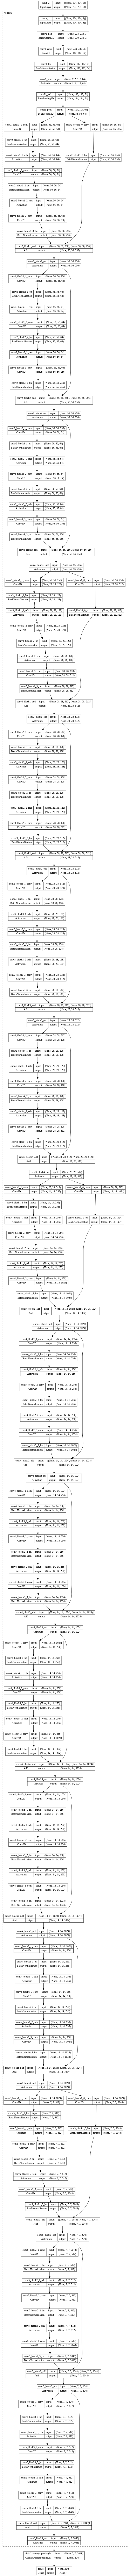

In [ ]:
tf.keras.utils.plot_model(model, show_shapes=True, expand_nested=True, dpi=64)

#6. Training the model

Training the model using data augmentation

In [ ]:
train_generator = datagen_train.flow(x_train, y_train, batch_size=32)
test_generator = datagen_test.flow(x_test, y_test, batch_size=32)

**EarlyStopping**: A function that monitors a specific metric and stops training if the metric does not improve for a specified number of epochs.
This good for preventing overfitting and can reduce the training time by halting the training process when it is no longer yielding better results.

In [ ]:
early_stopping = EarlyStopping(
    monitor='val_loss',          # Monitor validation loss
    mode='min',
    patience = 4,                  # Number of epochs with no improvement after which training will be stopped
    restore_best_weights=True    # Restore model weights from the epoch with the best value of the monitored metric
)

In [ ]:
history = model.fit(
    train_generator, # The generator that provides batches of training data
    epochs=25 , #sets the maximum number of times the model will iterate over the entire training dataset.
    validation_data=test_generator, #the data the model will use to evaluate its performance after each epoch.
    callbacks=[early_stopping] # List of callbacks to apply during training, like early stopping.
)

Epoch 1/25


/usr/local/lib/python3.10/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


181/181 ━━━━━━━━━━━━━━━━━━━━ 81s 371ms/step - accuracy: 0.6295 - loss: 0.9602 - val_accuracy: 0.8360 - val_loss: 0.4372
Epoch 2/25
181/181 ━━━━━━━━━━━━━━━━━━━━ 58s 306ms/step - accuracy: 0.8731 - loss: 0.3531 - val_accuracy: 0.8627 - val_loss: 0.3550
Epoch 3/25
181/181 ━━━━━━━━━━━━━━━━━━━━ 59s 311ms/step - accuracy: 0.8883 - loss: 0.2932 - val_accuracy: 0.8856 - val_loss: 0.3134
Epoch 4/25
181/181 ━━━━━━━━━━━━━━━━━━━━ 58s 308ms/step - accuracy: 0.9177 - loss: 0.2497 - val_accuracy: 0.8917 - val_loss: 0.2854
Epoch 5/25
181/181 ━━━━━━━━━━━━━━━━━━━━ 58s 311ms/step - accuracy: 0.9050 - loss: 0.2541 - val_accuracy: 0.8963 - val_loss: 0.2690
Epoch 6/25
181/181 ━━━━━━━━━━━━━━━━━━━━ 57s 303ms/step - accuracy: 0.9102 - loss: 0.2367 - val_accuracy: 0.8924 - val_loss: 0.2792
Epoch 7/25
181/181 ━━━━━━━━━━━━━━━━━━━━ 57s 305ms/step - accuracy: 0.9197 - loss: 0.2315 - val_accuracy: 0.8932 - val_loss: 0.2871
Epoch 8/25
181/181 ━━━━━━━━━━━━━━━━━━━━ 57s 305ms/step - accuracy: 0.9154 - loss: 0.2402 - val

# 7. Results & Evaluation of the model
**model.evaluate()**: This method provides a straightforward way to evaluate your model on the test dataset and obtain metrics like loss and accuracy.

In [ ]:
test_loss, test_acc = model.evaluate(x_test, y_test)
print(f'Test Loss: {test_loss}')
print(f'Test Accuracy: {test_acc}')

41/41 ━━━━━━━━━━━━━━━━━━━━ 7s 83ms/step - accuracy: 0.8982 - loss: 0.2771
Test Loss: 0.1886209398508072
Test Accuracy: 0.9282990097999573


###Ploting Training Vs Validation Loss
Helps understanding how the model's loss evolved over time, particularly during the most effective training period.

In [ ]:
history_df = pd.DataFrame(history.history) #Converting all araining History to DataFrame

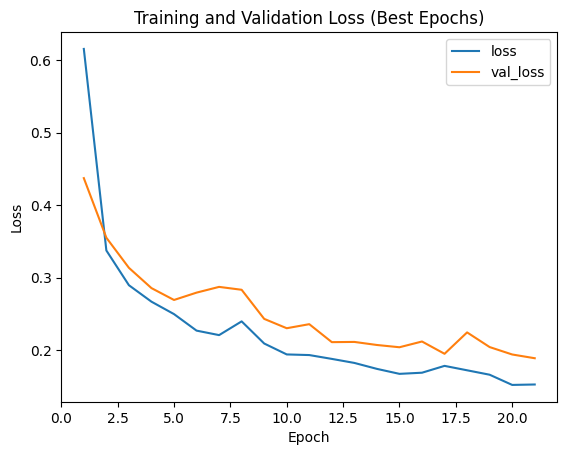

In [ ]:
history_df.loc[:, ['loss', 'val_loss']].plot(title='Training and Validation Loss (Best Epochs)')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.show()

###Ploting Training Vs Validation Accuracy
visualizing how well the model's predictions matched the actual labels in the most effective training period.

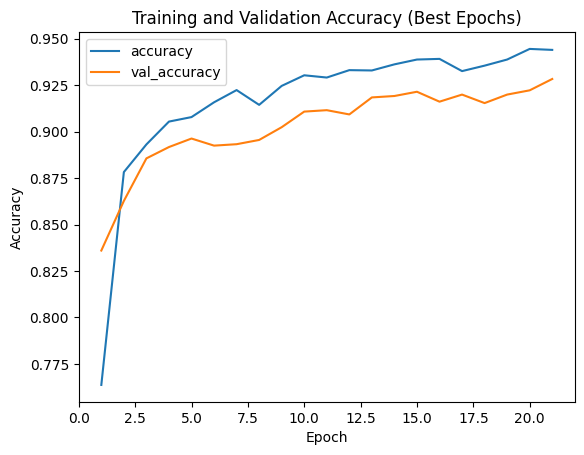

In [ ]:
history_df.loc[:, ['accuracy', 'val_accuracy']].plot(title='Training and Validation Accuracy (Best Epochs)')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.show()

In [ ]:
y_pred = model.predict(test_generator)
y_pred_classes = np.argmax(y_pred, axis=1)  # Get the class with highest probability
y_true_classes = np.argmax(y_test, axis=1)  # True labels from the test set

41/41 ━━━━━━━━━━━━━━━━━━━━ 2s 36ms/step


###confusion matrix

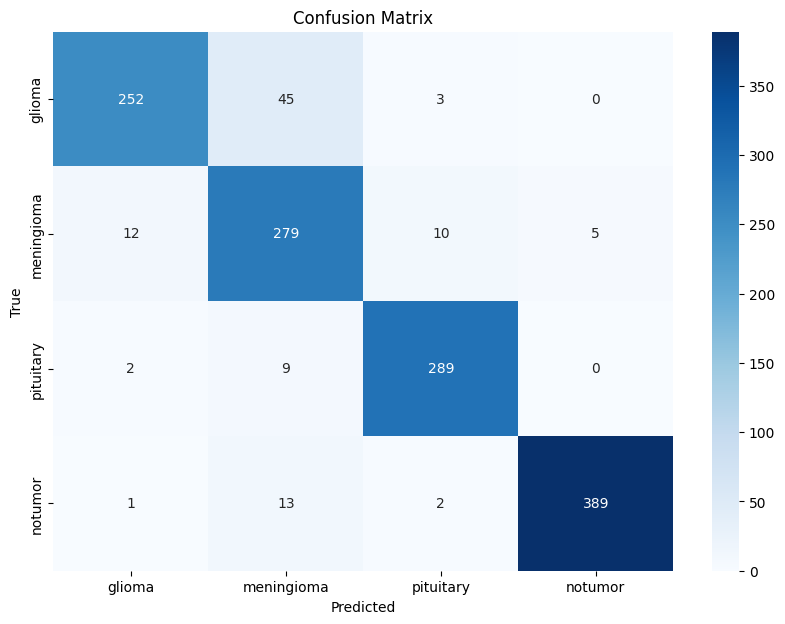

In [ ]:
cm = confusion_matrix(y_true_classes, y_pred_classes)
plt.figure(figsize=(10, 7))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=labels, yticklabels=labels)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()

## Results Discussion
The training accuracy improved from 62.95% in the first epoch to 94.61% by the 25th epoch. what shows a strong improvement in the model prediction of the correct class during training. The validation accuracy started at 83.60% (heigher then training accuracy at the start point) and increased to 92.37% by the end of training. This indicates that the model's performance on unseen data is also improving.
About the models loss,the training loss decreased from 0.9602 in the first epoch to 0.1494 by epoch 25, indicating that the model was learning and improving its predictions over time. The validation loss decreased from 0.4372 to 0.2080, showing that the model is not only improving its accuracy but also reducing the error in its predictions on the validation set.
in an overall view I can see that the model improved from one epoch to another but there were some small decreasing in epochs 6,12,16,18,22 and 24 - that indicates that The learning rate might be too high.


As we can see in the training results, which also shown in "Training Vs Validation Accuracy" and "Training Vs Validation Loss" graphs, the training accuracy is not significantly higher than the validation accuracy, they are both improving. and the validation loss is not increasing while the training loss is decreasing, so I can conclude that there is not overfitting or underfitting.And since early stopping was used with patience set to 4 epochs, and the model was trained for 25 epochs, it indicates that early stopping did not trigger, suggesting that the model kept improving without any plateauing that would have necessitated stopping.







#8. Fine Tuning

before training the model again I would like to decrease the 'patience' in early_stopping.Since fine-tuning involves adjusting layers that were previously frozen, the model might converge faster or show signs of overfitting sooner. Therefore, a lower patience value can help capture the best point of performance. In addition I will define the learning rate to be smaller, A smaller learning rate helps in gradually moving towards the optimal set of weights. Furtheremore, the goal in fine tuning is to adapt the pre-trained model to the specific task without losing the useful features learned during pre-training. A smaller learning rate ensures that the model does not "forget" the general features it has already learned, preserving the benefit of transfer learning. and finally, Fine-tuning with a smaller learning rate usually results in more stable convergence. The model is less likely to encounter abrupt changes in the loss function, leading to smoother and more reliable improvements in performance metrics.

Fine tuning requires less epochs, because the model is already partially trained. The goal is to make fine adjustments to improve performance further.

In [ ]:
early_stopping = EarlyStopping(
    monitor='val_loss',
     mode='min',
    patience = 3,                  # smaller number of epochs with no improvement after which training will be stopped
    restore_best_weights=True
)

Fine-Tuning:

In [ ]:
# Unfreezing the base model = all the layers in the base_model are trainable now
base_model.trainable = True

# After changing the trainable attribute for all layers in the model, I am recompiling the model
model.compile(optimizer=Adam(learning_rate = 0.00001),  # defining the LR to be very small (following the results discussion above)
              loss=CategoricalCrossentropy(),
              metrics=['accuracy'])

In [ ]:
model.summary()

Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_4 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 resnet50 (Functional)       (None, 7, 7, 2048)        23587712  
                                                                 
 global_average_pooling2d_1  (None, 2048)              0         
  (GlobalAveragePooling2D)                                       
                                                                 
 dense_1 (Dense)             (None, 4)                 8196      
                                                                 
Total params: 23595908 (90.01 MB)
Trainable params: 23542788 (89.81 MB)
Non-trainable params: 53120 (207.50 KB)
_________________________________________________________________


In [ ]:
history = model.fit(
    train_generator, # The generator that provides batches of training data
    epochs=10 , #smaller maximum number epochs
    validation_data=test_generator, #the model will use to evaluate its performance after each epoch.
    callbacks=[early_stopping]
)

Epoch 1/10
181/181 ━━━━━━━━━━━━━━━━━━━━ 144s 471ms/step - accuracy: 0.8554 - loss: 0.4294 - val_accuracy: 0.8886 - val_loss: 0.3251
Epoch 2/10
181/181 ━━━━━━━━━━━━━━━━━━━━ 59s 312ms/step - accuracy: 0.9317 - loss: 0.1917 - val_accuracy: 0.8474 - val_loss: 0.4656
Epoch 3/10
181/181 ━━━━━━━━━━━━━━━━━━━━ 59s 315ms/step - accuracy: 0.9531 - loss: 0.1313 - val_accuracy: 0.9451 - val_loss: 0.1742
Epoch 4/10
181/181 ━━━━━━━━━━━━━━━━━━━━ 59s 314ms/step - accuracy: 0.9632 - loss: 0.1072 - val_accuracy: 0.9619 - val_loss: 0.1138
Epoch 5/10
181/181 ━━━━━━━━━━━━━━━━━━━━ 59s 316ms/step - accuracy: 0.9752 - loss: 0.0755 - val_accuracy: 0.9664 - val_loss: 0.0943
Epoch 6/10
181/181 ━━━━━━━━━━━━━━━━━━━━ 59s 314ms/step - accuracy: 0.9739 - loss: 0.0766 - val_accuracy: 0.9680 - val_loss: 0.0822
Epoch 7/10
181/181 ━━━━━━━━━━━━━━━━━━━━ 59s 312ms/step - accuracy: 0.9840 - loss: 0.0505 - val_accuracy: 0.9756 - val_loss: 0.0668
Epoch 8/10
181/181 ━━━━━━━━━━━━━━━━━━━━ 59s 315ms/step - accuracy: 0.9856 - loss: 

#9. Results & Evaluation After Fine Tuning:

In [ ]:
test_loss, test_acc = model.evaluate(x_test, y_test)
print(f'Test Loss: {test_loss}')
print(f'Test Accuracy: {test_acc}')

41/41 ━━━━━━━━━━━━━━━━━━━━ 7s 78ms/step - accuracy: 0.9834 - loss: 0.0538
Test Loss: 0.0355665385723114
Test Accuracy: 0.9885583519935608


###Confusion Matrix:

In [ ]:
predictions = model.predict(x_test)
predicted_classes = np.argmax(predictions, axis=1)
true_classes = np.argmax(y_test, axis=1)

41/41 ━━━━━━━━━━━━━━━━━━━━ 8s 118ms/step


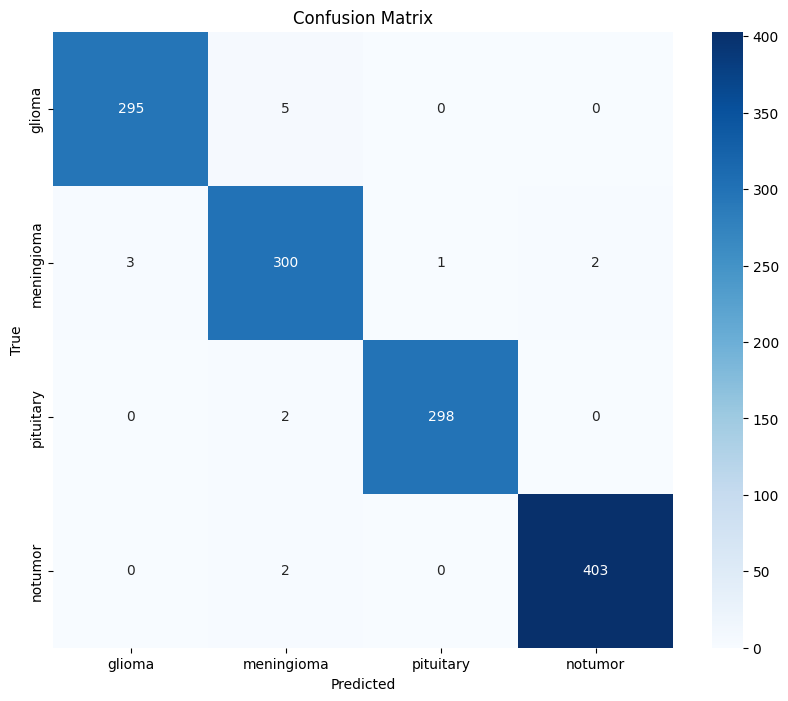

In [ ]:
cm = confusion_matrix(true_classes, predicted_classes)
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=labels, yticklabels=labels)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()

###Classification Report:

In [ ]:
report = classification_report(true_classes, predicted_classes, target_names=labels)
print('Classification Report:\n', report)

Classification Report:
               precision    recall  f1-score   support

      glioma       0.99      0.98      0.99       300
  meningioma       0.97      0.98      0.98       306
   pituitary       1.00      0.99      0.99       300
     notumor       1.00      1.00      1.00       405

    accuracy                           0.99      1311
   macro avg       0.99      0.99      0.99      1311
weighted avg       0.99      0.99      0.99      1311



*Precision - The ratio of correctly predicted positive observations to the total predicted positives.           
*Recall / Sensitivity - The ratio of correctly predicted positive observations to the all observations in the actual class.             
*F1-Score - The harmonic mean of precision and recall.             
*Support - The number of actual occurrences of the class in the dataset.       
*Accuracy - Overall accuracy of the model.


###Ploting Training Vs Validation Loss, Training Vs Validation Accuracy graphs as above, but now on models training record after fine tuning.

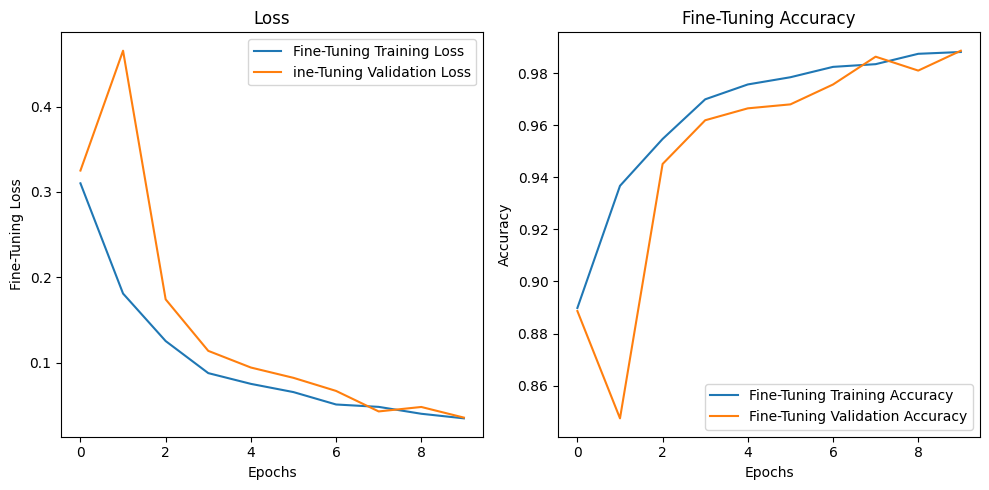

In [ ]:
plt.figure(figsize=(10, 5))
#Loss
plt.subplot(1, 2, 1)
plt.plot(history.history['loss'], label='Fine-Tuning Training Loss')
plt.plot(history.history['val_loss'], label='ine-Tuning Validation Loss')
plt.title('Loss')
plt.xlabel('Epochs')
plt.ylabel('Fine-Tuning Loss')
plt.legend()

# Accuracy
plt.subplot(1, 2, 2)
plt.plot(history.history['accuracy'], label='Fine-Tuning Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Fine-Tuning Validation Accuracy')
plt.title('Fine-Tuning Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.tight_layout()
plt.show()

#Some example sample predictions

In [ ]:
def display_sample_predictions(images, true_labels, pred_labels, class_names, num_samples=5):
    plt.figure(figsize=(15, 10))
    for i in range(num_samples):
        plt.subplot(1, num_samples, i + 1)
        plt.imshow(images[i])
        plt.title(f'True: {class_names[np.argmax(true_labels[i])]} \nPred: {class_names[pred_labels[i]]}')
        plt.axis('off')
    plt.show()

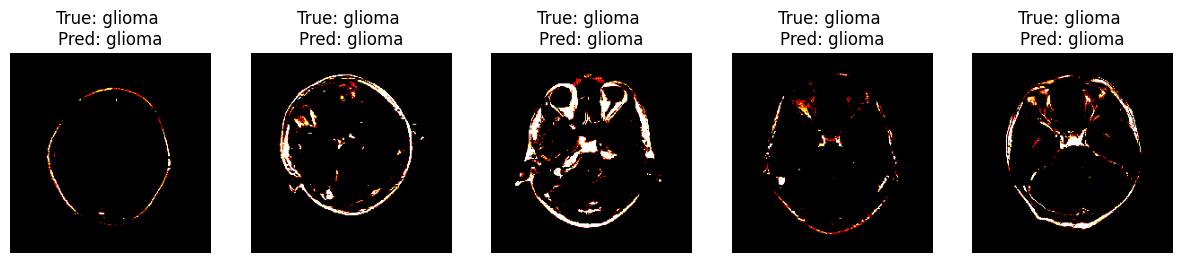

In [ ]:
display_sample_predictions(x_test, y_test, predicted_classes, labels)

#10.Conclusion & Further Suggestions
##Conclusion:
There is a significant improvement in the final results dou to the fine tuning, in the 10 epoch of training after fine tuning, the validation accuracy gets to 0.9886 (98.86%) with 0.0356 loss ,and the training accuracy to 0.9885 (98.85%) with 0.0304 loss. VS after 25 epochs before fine tuning when the validation accuracy got to 0.9237 (92.37%) with loss of 0.2080 and training accuracy got to 0.9461 (94.61%) with loos of 0.1494.The model made rapid improvements in both accuracy and loss within just 10 epochs. This shows that the fine-tuning process was effective in optimizing the model.

In addition to the better results, the fine tuning improves the model’s performance consistentns. Both training and validation accuracy steadily improving and maintaining high levels without significant drops, what also suggests that there was no overfitting during the fine-tuning process.

This training record visualize the improvement with Fine-Tuning!
Compared to initial training, the fine-tuned model has shown improved accuracy and lower loss, particularly with a smaller learning rate, which likely helped in refining the model without overshooting the optimal weights.

The fine-tuning process significantly enhanced the model’s performance, bringing both training and validation accuracy to nearly 99%. This indicates a well-trained model that is likely to perform well in real-world applications. needed to mention that in the last few epochs  the validation los is still decreasing, what may indicate that maybe the model can preform even better with a few more epoch of training.




##Further Suggestions:
**Further Testing:** To ensure the robustness of the model, I would test it on a separate test set or unseen data to verify its performance further.
In addition, I recomend to preforming testing on data from different distributions or hospitals.

**Expanding the Dataset:** Using more diverse datasets, possibly incorporating multimodal data (like, combining MRI with other imaging modalities or patient data).

**Data Augmentation Techniques:** Experimenting with more advanced data augmentation techniques in order to adjust model generalization for rare tumor types.

**Level up the multiclasification and preform tumors segmantation:**
semantic segmentation is the process of classifying each pixel in an image into a predefined category. All pixels belonging to the same class are given the same label. in that way the model will classifay and locate brain tumores


#11. Difficulties along the way

During working on this project I experienced many difficulties, mainly technical.
First, I could not load my into google colab event after I upload the images to google drive. Every time I tried to run my Loading and Preprocesessing code my google colab crashed.
After I paid to google colab in order to get the option to succeed loading my data, it took anly one day until google colab "told" me that I need to pay again.

In addition to those problems, each run of my full code takes about 40-45 minuts (becuase of my data - more then 7,000 MRI images), so for every small change I needed to wait a lot. but the main problem was that the googel colab kept disconnecting while the code ran or when I was codding, so almost every time I add or change somthing I needed to run all, and many times in the middle of running the code it disconnect and I was required to run all from the begining and wait again.

I must say, that working on this project was very hard, especially because I did it alone, but I enjoyed researching,exploring by myself.  I definitely learnd and upgraded my skilles in all matters of this project.

# Clear the Memory

In [ ]:
import IPython
app = IPython.Application.instance()
app.kernel.do_shutdown(True)